*  Before starting, click "Runtime" in the top panel, select "Change runtime type" and then choose "GPU"

*  This tutorial follows the lsds tutorial, and is therefore condensed. Check out the lsds tutorial (**train_lsds.ipynb**) if there is any confusion throughout

*  Try running each cell consecutively to see what is happening before changing things around

*  Some cells are collapsed by default, these are generally utility functions or are expanded by defaullt in a previous tutorial. Double click to expand/collapse

*  sometimes colab can be slow when training, if this happens you may need to restart the runtime. also, you generally can only run one session at a time.

In [1]:
#@title import packages

import gunpowder as gp
import h5py
import io
import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import requests
import torch
import zarr

from funlib.learn.torch.models import UNet, ConvPass
from gunpowder.torch import Train
from lsd.train.gp import AddLocalShapeDescriptor
from tqdm import tqdm

%matplotlib inline
logging.basicConfig(level=logging.INFO)

In [2]:
#@title utility function to view labels

# matplotlib uses a default shader
# we need to recolor as unique objects

def create_lut(labels):

    max_label = np.max(labels)

    lut = np.random.randint(
            low=0,
            high=255,
            size=(int(max_label + 1), 3),
            dtype=np.uint8)

    lut = np.append(
            lut,
            np.zeros(
                (int(max_label + 1), 1),
                dtype=np.uint8) + 255,
            axis=1)

    lut[0] = 0
    colored_labels = lut[labels]

    return colored_labels

In [3]:
#@title utility  function to download / save data as zarr

def create_data(
    url, 
    name, 
    offset, 
    resolution,
    sections=None,
    squeeze=True):

  in_f = h5py.File(io.BytesIO(requests.get(url).content), 'r')

  raw = in_f['volumes/raw']
  labels = in_f['volumes/labels/neuron_ids']
  
  container = zarr.open(name, 'a')

  if sections is None:
    sections=range(raw.shape[0]-1)

  for index, section in enumerate(sections):

    print(f'Writing data for section {section}')

    raw_slice = raw[section]
    labels_slice = labels[section]

    if squeeze:
      raw_slice = np.squeeze(raw_slice)
      labels_slice = np.squeeze(labels_slice)

    for ds_name, data in [
        ('raw', raw_slice),
        ('labels', labels_slice)]:
        
        container[f'{ds_name}/{index}'] = data
        container[f'{ds_name}/{index}'].attrs['offset'] = offset
        container[f'{ds_name}/{index}'].attrs['resolution'] = resolution

In [4]:
#@title utility function to view a batch

# matplotlib.pyplot wrapper to view data
# default shape should be 2 - 2d data

def imshow(
        raw=None,
        ground_truth=None,
        target=None,
        prediction=None,
        h=None,
        shader='jet',
        subplot=True,
        channel=0,
        target_name='target',
        prediction_name='prediction'):

    rows = 0

    if raw is not None:
        rows += 1
        cols = raw.shape[0] if len(raw.shape) > 2 else 1
    if ground_truth is not None:
        rows += 1
        cols = ground_truth.shape[0] if len(ground_truth.shape) > 2 else 1
    if target is not None:
        rows += 1
        cols = target.shape[0] if len(target.shape) > 2 else 1
    if prediction is not None:
        rows += 1
        cols = prediction.shape[0] if len(prediction.shape) > 2 else 1

    if subplot:
        fig, axes = plt.subplots(
            rows,
            cols,
            figsize=(10, 4),
            sharex=True,
            sharey=True,
            squeeze=False)

    if h is not None:
        fig.subplots_adjust(hspace=h)

    def wrapper(data,row,name="raw"):

        if subplot:
            if len(data.shape) == 2:
                if name == 'raw':
                    axes[0][0].imshow(data, cmap='gray')
                    axes[0][0].set_title(name)
                else:
                    axes[row][0].imshow(create_lut(data))
                    axes[row][0].set_title(name)

            elif len(data.shape) == 3:
                for i, im in enumerate(data):
                    if name == 'raw':
                        axes[0][i].imshow(im, cmap='gray')
                        axes[0][i].set_title(name)
                    else:
                        axes[row][i].imshow(create_lut(im))
                        axes[row][i].set_title(name)

            else:
                for i, im in enumerate(data):
                    axes[row][i].imshow(im[channel], cmap=shader)
                    axes[row][i].set_title(name)


        else:
            if name == 'raw':
                plt.imshow(data, cmap='gray')
            if name == 'labels':
                plt.imshow(data, alpha=0.5)

    row=0 

    if raw is not None:
        wrapper(raw,row=row)
        row += 1
    if ground_truth is not None:
        wrapper(ground_truth,row=row,name='labels')
        row += 1
    if target is not None:
        wrapper(target,row=row,name=target_name)
        row += 1
    if prediction is not None:
        wrapper(prediction,row=row,name=prediction_name)
        row += 1

    plt.show()

In [5]:
create_data(
    'https://cremi.org/static/data/sample_A_20160501.hdf',
    'training_data.zarr',
    offset=[0,0],
    resolution=[4,4])

Writing data for section 0
Writing data for section 1
Writing data for section 2
Writing data for section 3
Writing data for section 4
Writing data for section 5
Writing data for section 6
Writing data for section 7
Writing data for section 8
Writing data for section 9
Writing data for section 10
Writing data for section 11
Writing data for section 12
Writing data for section 13
Writing data for section 14
Writing data for section 15
Writing data for section 16
Writing data for section 17
Writing data for section 18
Writing data for section 19
Writing data for section 20
Writing data for section 21
Writing data for section 22
Writing data for section 23
Writing data for section 24
Writing data for section 25
Writing data for section 26
Writing data for section 27
Writing data for section 28
Writing data for section 29
Writing data for section 30
Writing data for section 31
Writing data for section 32
Writing data for section 33
Writing data for section 34
Writing data for section 35
Wr

In [6]:
voxel_size = gp.Coordinate((4, 4))

input_shape = gp.Coordinate((164, 164))
output_shape = gp.Coordinate((124, 124))

input_size = input_shape * voxel_size
output_size = output_shape * voxel_size

num_samples=124
batch_size=5

In [7]:
# mtlsd model - designed to use lsds as an auxiliary learning task for improving affinities
# raw --> lsds / affs

# wrap model in a class. need two out heads, one for lsds, one for affs

class MtlsdModel(torch.nn.Module):

    def __init__(
        self,
        in_channels,
        num_fmaps,
        fmap_inc_factor,
        downsample_factors,
        kernel_size_down,
        kernel_size_up,
        constant_upsample):
  
        super().__init__()

        # create unet
        self.unet = UNet(
          in_channels=in_channels,
          num_fmaps=num_fmaps,
          fmap_inc_factor=fmap_inc_factor,
          downsample_factors=downsample_factors,
          kernel_size_down=kernel_size_down,
          kernel_size_up=kernel_size_up,
          constant_upsample=constant_upsample)

        # create lsd and affs heads
        self.lsd_head = ConvPass(num_fmaps, 6, [[1, 1]], activation='Sigmoid')
        self.aff_head = ConvPass(num_fmaps, 2, [[1, 1]], activation='Sigmoid')

    def forward(self, input):

        # pass raw through unet
        z = self.unet(input)

        # pass output through heads
        lsds = self.lsd_head(z)
        affs = self.aff_head(z)

        return lsds, affs

# combine the lsds and affs losses

class WeightedMSELoss(torch.nn.MSELoss):
    def __init__(self):
        super(WeightedMSELoss, self).__init__()

    def _calc_loss(self, pred, target, weights):

        scaled = weights * (pred - target) ** 2

        if len(torch.nonzero(scaled)) != 0:
            mask = torch.masked_select(scaled, torch.gt(weights, 0))
            loss = torch.mean(mask)

        else:
            loss = torch.mean(scaled)

        return loss

    def forward(
        self,
        lsds_prediction,
        lsds_target,
        lsds_weights,
        affs_prediction,
        affs_target,
        affs_weights,
    ):

        # calc each loss and combine
        loss1 = self._calc_loss(lsds_prediction, lsds_target, lsds_weights)
        loss2 = self._calc_loss(affs_prediction, affs_target, affs_weights)

        return loss1 + loss2

In [8]:
def train(
    iterations,
    show_every,
    show_gt=True,
    show_pred=False,
    lsd_channels=None,
    aff_channels=None):

    raw = gp.ArrayKey('RAW')
    labels = gp.ArrayKey('LABELS')
    gt_lsds = gp.ArrayKey('GT_LSDS')
    lsds_weights = gp.ArrayKey('LSDS_WEIGHTS')
    pred_lsds = gp.ArrayKey('PRED_LSDS')
    gt_affs = gp.ArrayKey('GT_AFFS')
    affs_weights = gp.ArrayKey('AFFS_WEIGHTS')
    pred_affs = gp.ArrayKey('PRED_AFFS')

    in_channels=1
    num_fmaps=12
    fmap_inc_factor=5
    ds_fact = [(2,2),(2,2)]
    num_levels = len(ds_fact) + 1
    ksd = [[(3,3), (3,3)]]*num_levels
    ksu = [[(3,3), (3,3)]]*(num_levels - 1)
    constant_upsample = True

    model = MtlsdModel(
        in_channels,
        num_fmaps,
        fmap_inc_factor,
        ds_fact,
        ksd,
        ksu,
        constant_upsample)
    
    loss = WeightedMSELoss()
    optimizer = torch.optim.Adam(lr=0.5e-4, params=model.parameters())

    request = gp.BatchRequest()
    request.add(raw, input_size)
    request.add(labels, output_size)
    request.add(gt_lsds, output_size)
    request.add(lsds_weights, output_size)
    request.add(pred_lsds, output_size)
    request.add(gt_affs, output_size)
    request.add(affs_weights, output_size)
    request.add(pred_affs, output_size)

    sources = tuple(
        gp.ZarrSource(
            'training_data.zarr',  
            {
                raw: f'raw/{i}',
                labels: f'labels/{i}'
            },  
            {
                raw: gp.ArraySpec(interpolatable=True),
                labels: gp.ArraySpec(interpolatable=False)
            }) + 
            gp.Normalize(raw) +
            gp.RandomLocation()
            for i in range(num_samples)
        )

    # raw:      (h, w)
    # labels:   (h, w)

    pipeline = sources

    pipeline += gp.RandomProvider()

    pipeline += gp.SimpleAugment()

    pipeline += gp.IntensityAugment(
        raw,
        scale_min=0.9,
        scale_max=1.1,
        shift_min=-0.1,
        shift_max=0.1)

    pipeline += gp.GrowBoundary(labels)

    pipeline += AddLocalShapeDescriptor(
        labels,
        gt_lsds,
        lsds_mask=lsds_weights,
        sigma=80,
        downsample=2)
        
    pipeline += gp.AddAffinities(
    affinity_neighborhood=[
        [0, -1],
        [-1, 0]],
    labels=labels,
    affinities=gt_affs,
    dtype=np.float32)

    pipeline += gp.BalanceLabels(
        gt_affs,
        affs_weights)

    pipeline += gp.Unsqueeze([raw])

    pipeline += gp.Stack(batch_size)

    pipeline += gp.PreCache(num_workers=10)

    pipeline += Train(
        model,
        loss,
        optimizer,
        inputs={
            'input': raw
        },
        outputs={
            0: pred_lsds,
            1: pred_affs
        },
        loss_inputs={
            0: pred_lsds,
            1: gt_lsds,
            2: lsds_weights,
            3: pred_affs,
            4: gt_affs,
            5: affs_weights
        },
        log_dir='train_mtlsd_logs')

    with gp.build(pipeline):
        progress = tqdm(range(iterations))
        for i in progress:
            batch = pipeline.request_batch(request)

            start = request[labels].roi.get_begin()/voxel_size
            end = request[labels].roi.get_end()/voxel_size

            if i % show_every == 0:
              
              imshow(raw=np.squeeze(batch[raw].data[:,:,start[0]:end[0],start[1]:end[1]]))
              imshow(ground_truth=batch[labels].data)

              if lsd_channels:
                for n,c in lsd_channels.items():
                  
                  if show_gt:
                    imshow(target=batch[gt_lsds].data, target_name='gt '+n, channel=c)
                  if show_pred:
                    imshow(prediction=batch[pred_lsds].data, prediction_name='pred '+n, channel=c)

              if aff_channels:
                for n,c in aff_channels.items():

                  if show_gt:
                    imshow(target=batch[gt_affs].data, target_name='gt '+n, channel=c)
                  if show_pred:
                    imshow(target=batch[pred_affs].data, target_name='pred '+n, channel=c)

              
            progress.set_description(f'Training iteration {i}') 
            pass

In [9]:
np.bool = np.bool_

INFO:gunpowder.torch.nodes.train:Resuming training from iteration 4000
INFO:gunpowder.torch.nodes.train:Loading model_checkpoint_4000
INFO:gunpowder.torch.nodes.train:Using device cuda
  0%|          | 0/1 [00:00<?, ?it/s]INFO:gunpowder.nodes.precache:starting new set of workers (10, cache size 50)...
INFO:gunpowder.nodes.generic_train:Train process: iteration=4001 loss=0.098876 time=0.340308


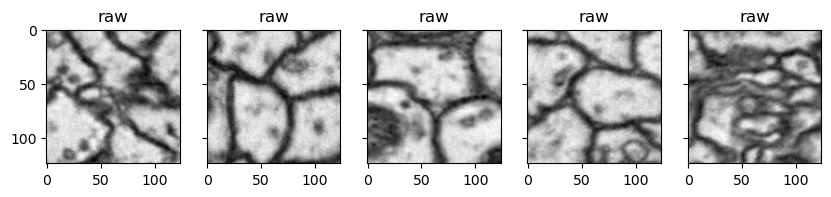

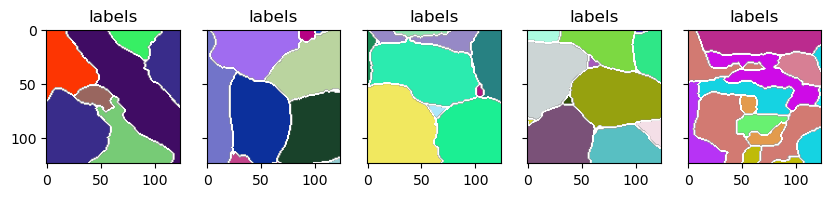

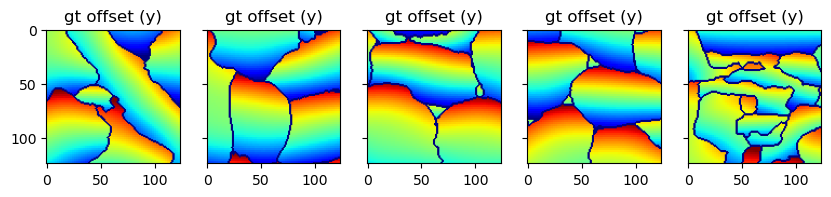

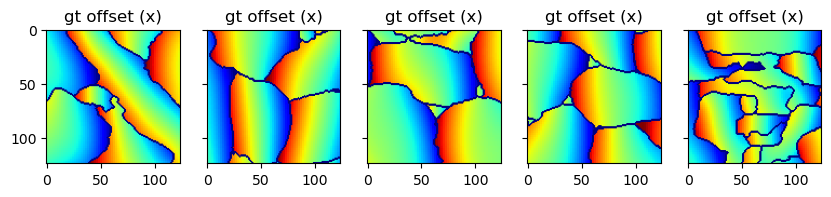

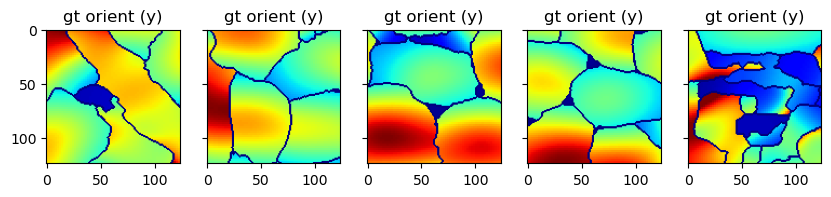

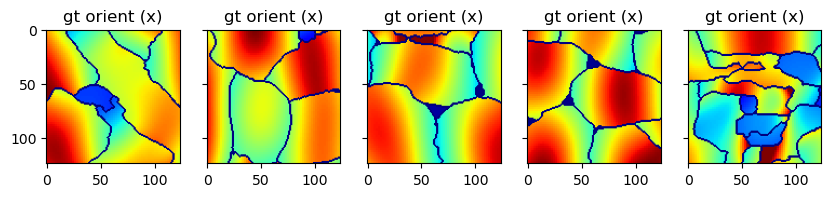

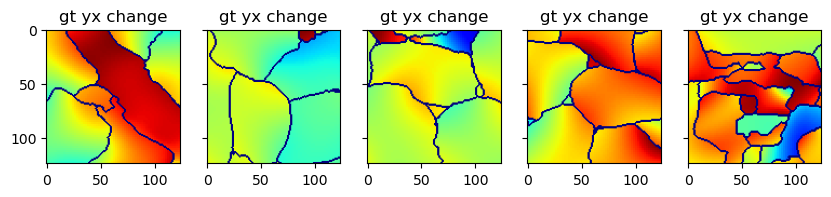

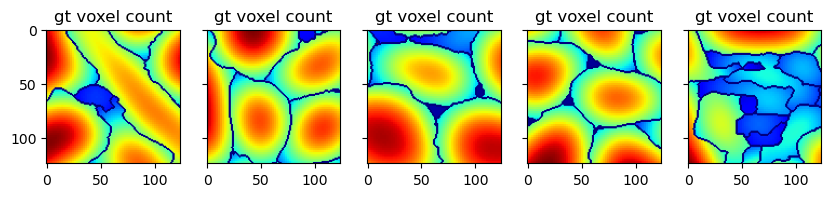

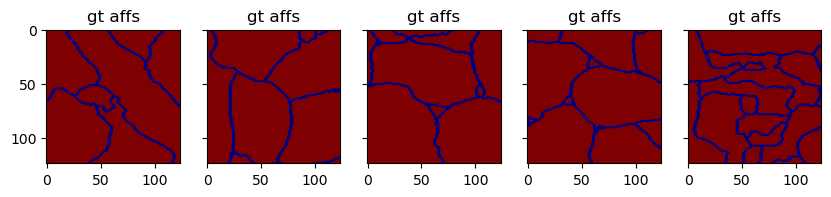

Training iteration 0: 100%|██████████| 1/1 [00:06<00:00,  6.39s/it]INFO:gunpowder.producer_pool:terminating workers...
INFO:gunpowder.producer_pool:joining workers...
INFO:gunpowder.producer_pool:done



In [10]:
# view a batch of ground truth lsds/affs, no need to show predicted lsds/affs yet

lsd_channels = {
    'offset (y)': 0,
    'offset (x)': 1,
    'orient (y)': 2,
    'orient (x)': 3,
    'yx change': 4,
    'voxel count': 5
}

#just view first y affs
aff_channels = {'affs': 0}

train(
    iterations=1,
    show_every=1,
    lsd_channels=lsd_channels,
    aff_channels=aff_channels)

INFO:gunpowder.torch.nodes.train:Resuming training from iteration 4000
INFO:gunpowder.torch.nodes.train:Loading model_checkpoint_4000
INFO:gunpowder.torch.nodes.train:Using device cuda
  0%|          | 0/2001 [00:00<?, ?it/s]INFO:gunpowder.nodes.precache:starting new set of workers (10, cache size 50)...
INFO:gunpowder.nodes.generic_train:Train process: iteration=4001 loss=0.073013 time=0.023092


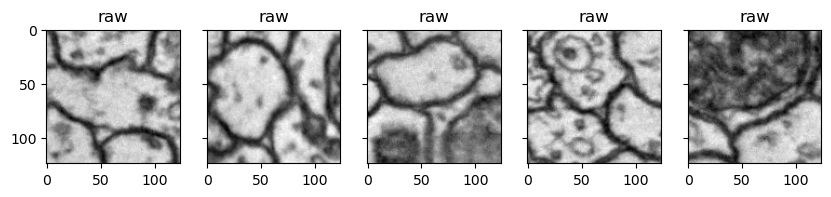

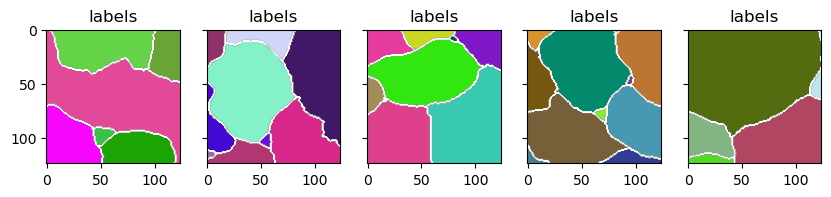

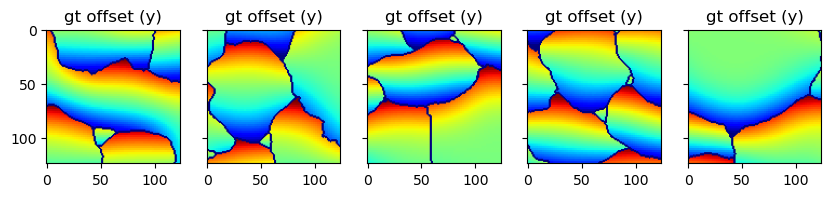

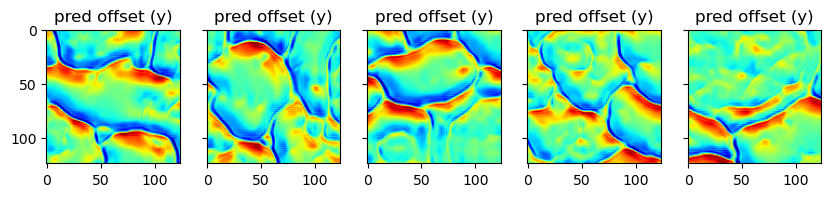

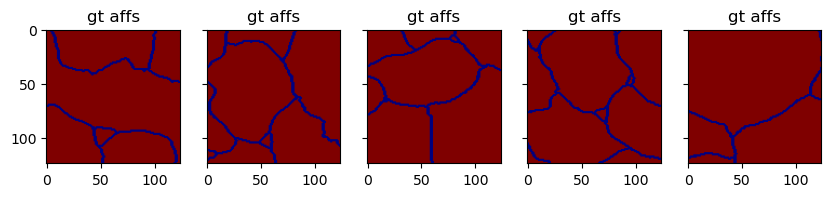

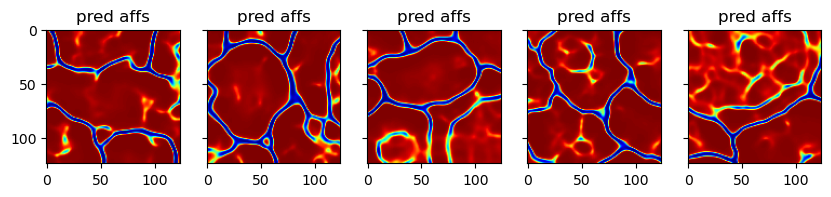

Training iteration 199:  10%|▉         | 200/2001 [00:47<06:41,  4.49it/s]INFO:gunpowder.nodes.generic_train:Train process: iteration=4201 loss=0.094795 time=0.013291


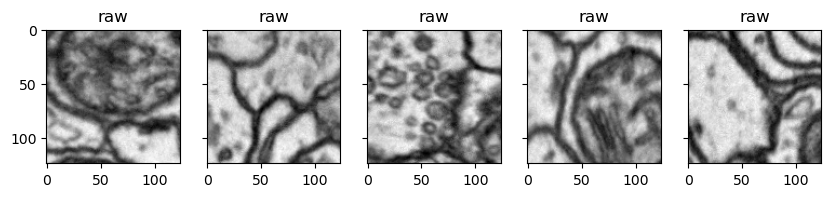

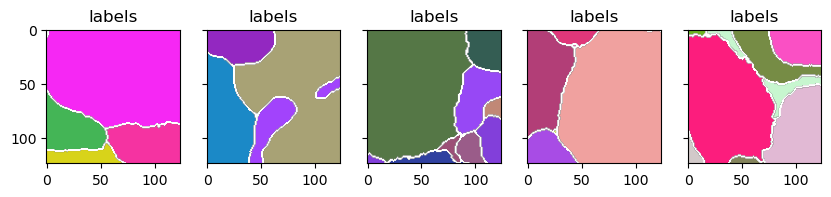

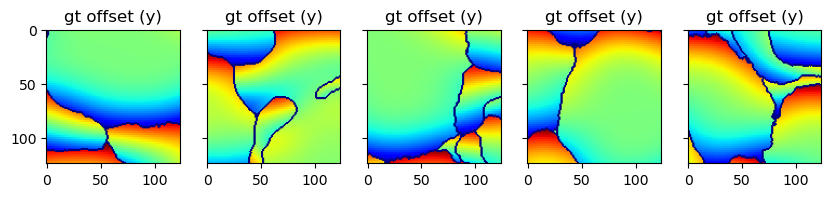

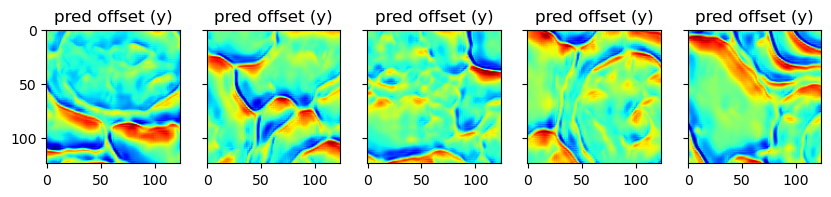

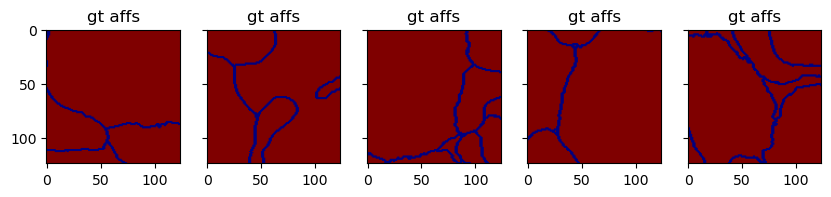

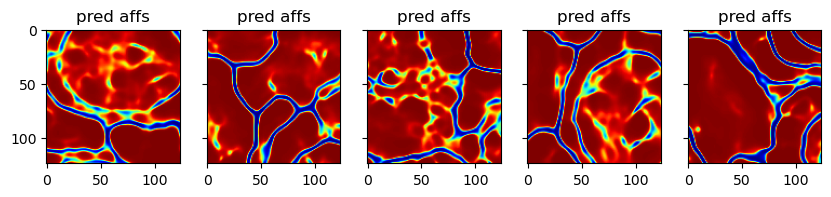

Training iteration 399:  20%|█▉        | 399/2001 [01:32<04:43,  5.65it/s]INFO:gunpowder.nodes.generic_train:Train process: iteration=4401 loss=0.077789 time=0.015419


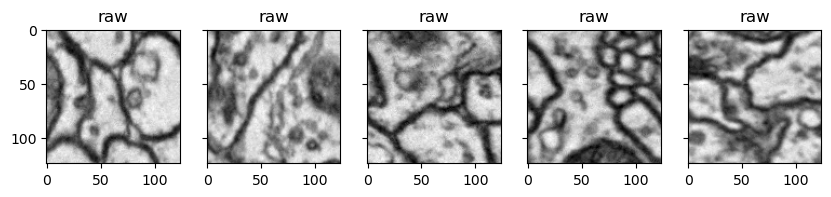

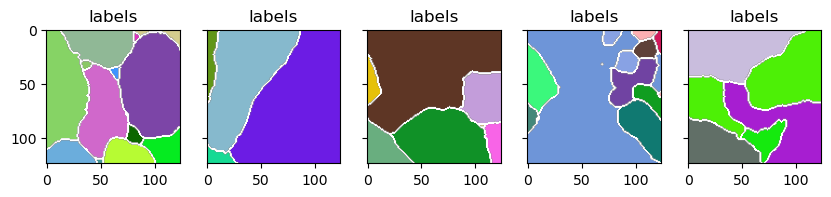

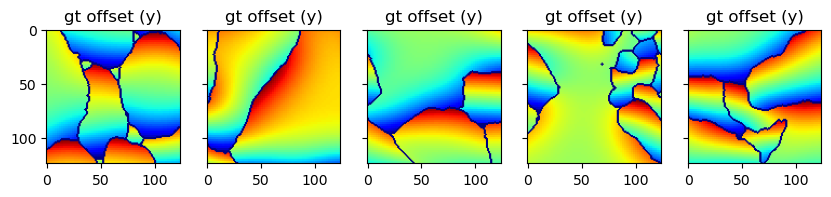

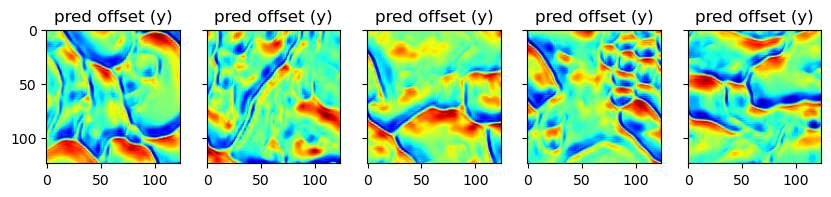

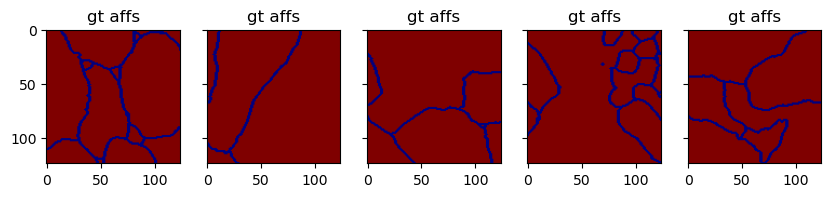

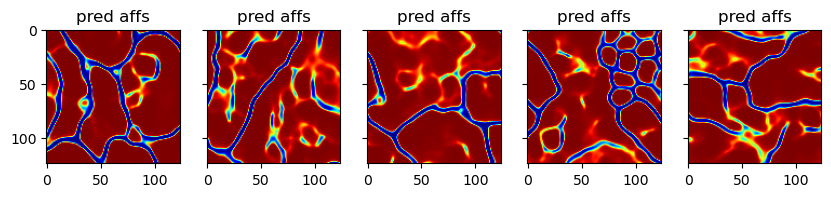

Training iteration 599:  30%|██▉       | 599/2001 [02:16<04:46,  4.90it/s]INFO:gunpowder.nodes.generic_train:Train process: iteration=4601 loss=0.079613 time=0.019294


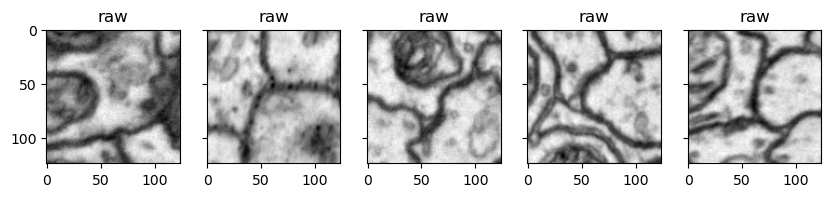

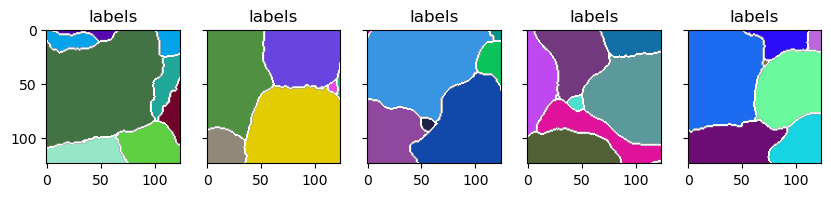

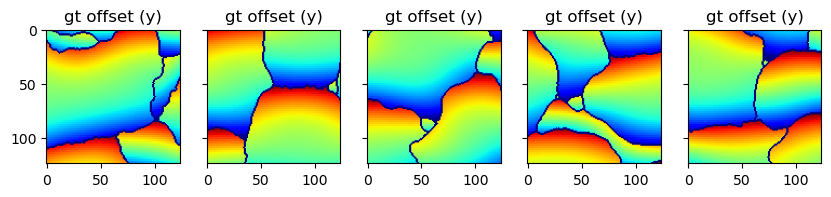

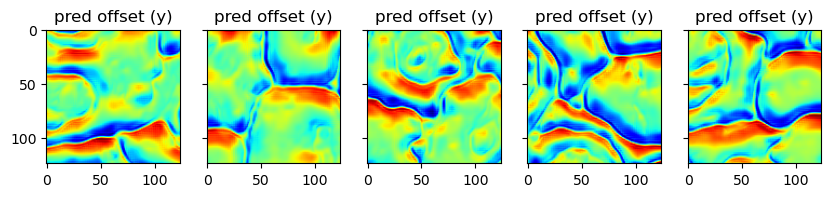

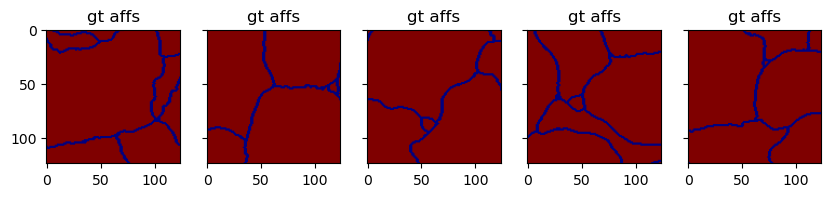

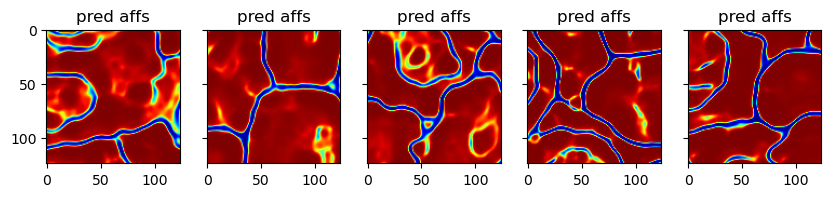

Training iteration 799:  40%|███▉      | 799/2001 [02:59<04:36,  4.35it/s]INFO:gunpowder.nodes.generic_train:Train process: iteration=4801 loss=0.072290 time=0.014786


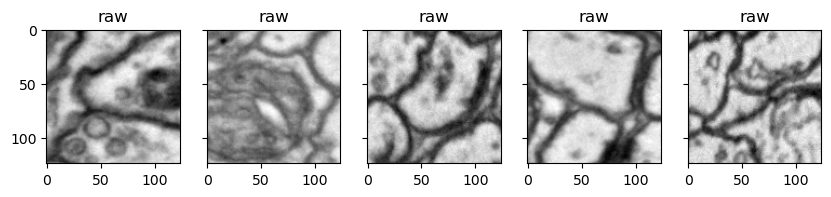

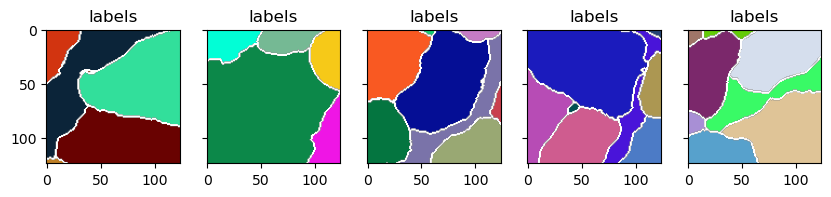

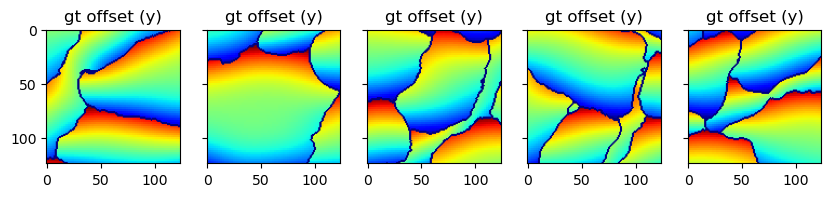

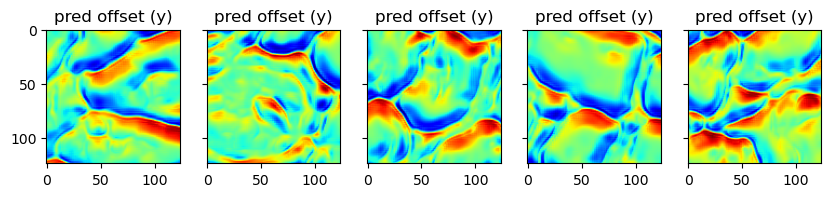

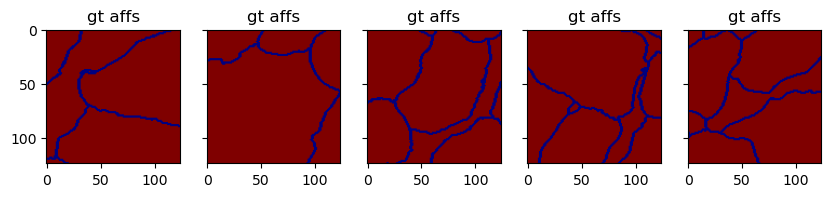

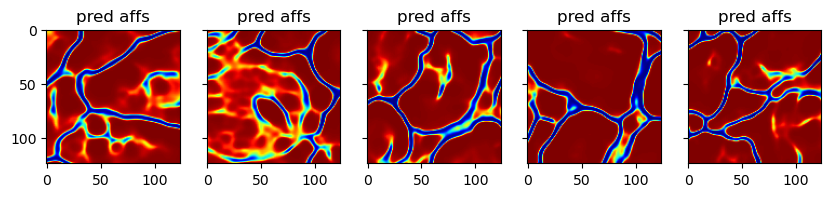

Training iteration 999:  50%|████▉     | 999/2001 [03:40<04:06,  4.07it/s]INFO:gunpowder.nodes.generic_train:Train process: iteration=5001 loss=0.074578 time=0.018161


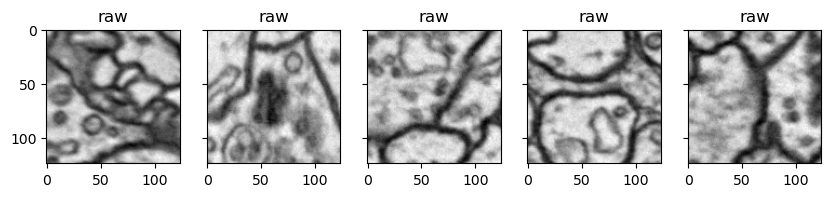

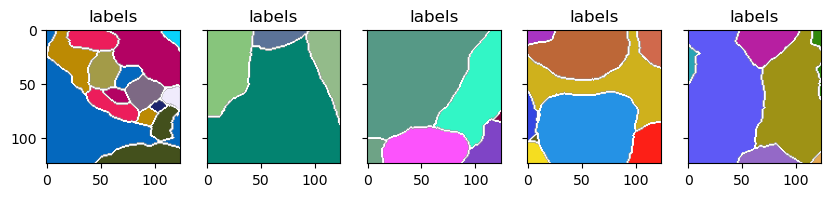

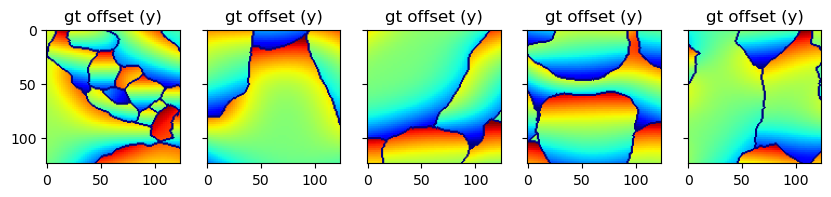

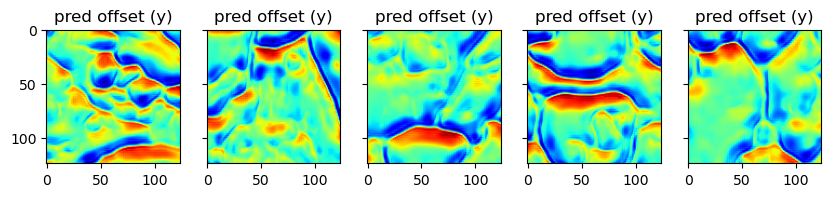

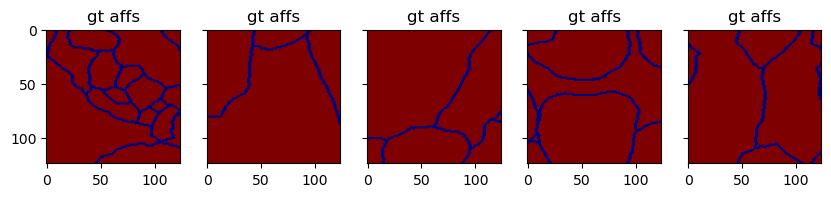

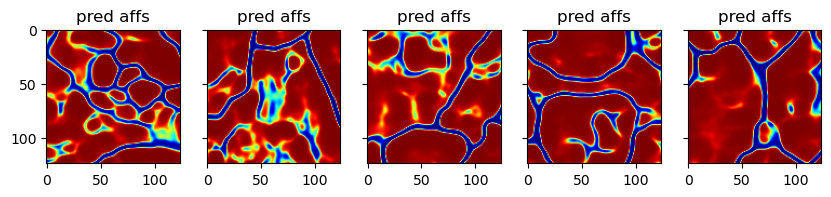

Training iteration 1199:  60%|█████▉    | 1200/2001 [04:23<02:42,  4.92it/s]INFO:gunpowder.nodes.generic_train:Train process: iteration=5201 loss=0.063705 time=0.016120


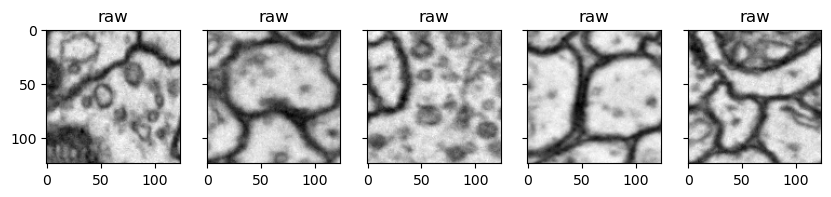

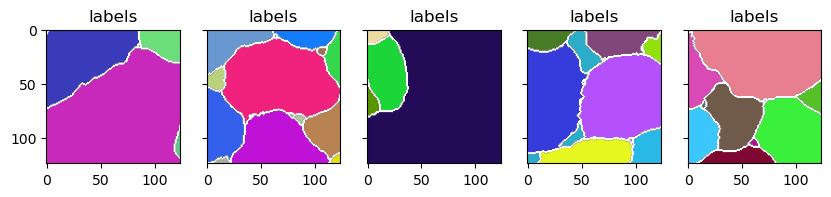

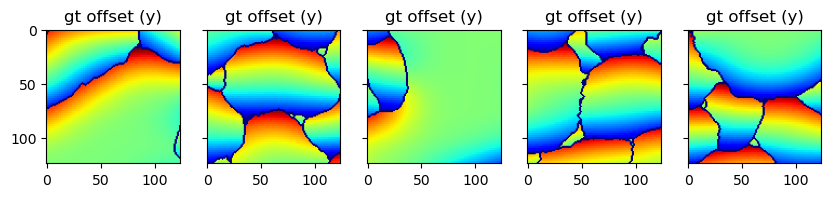

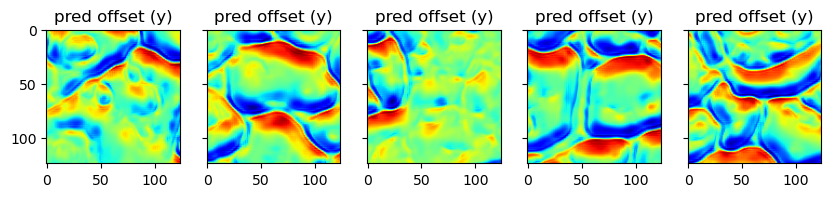

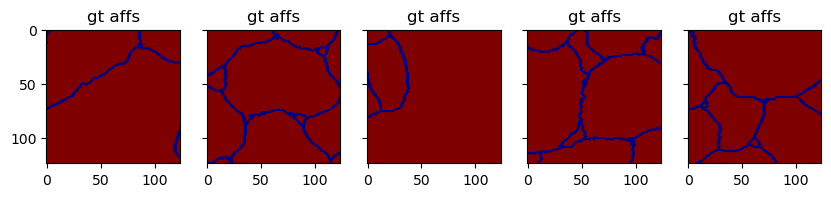

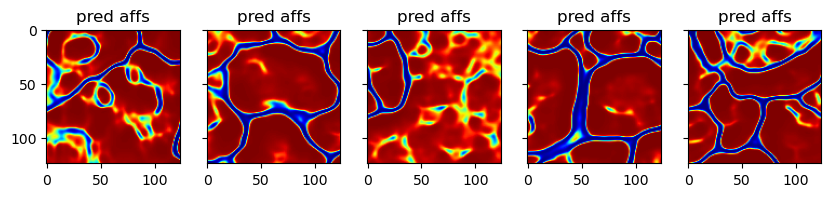

Training iteration 1399:  70%|██████▉   | 1399/2001 [05:04<01:55,  5.23it/s]INFO:gunpowder.nodes.generic_train:Train process: iteration=5401 loss=0.061687 time=0.013813


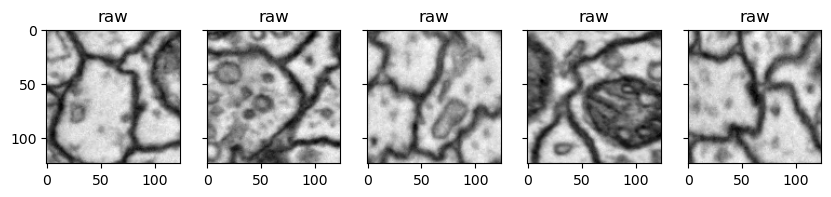

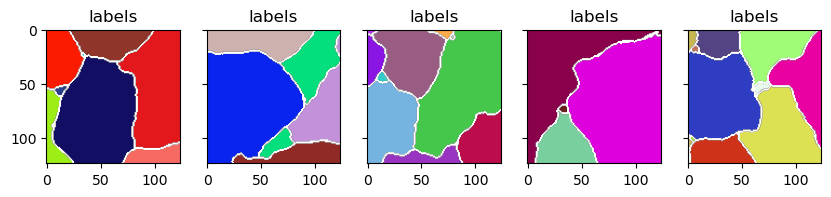

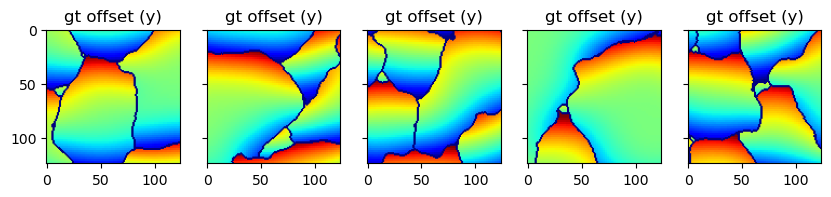

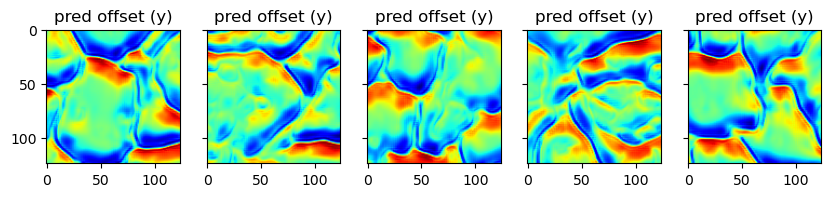

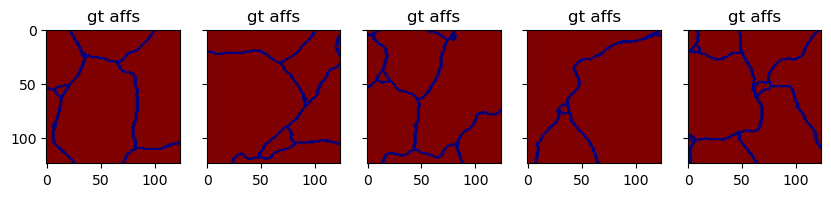

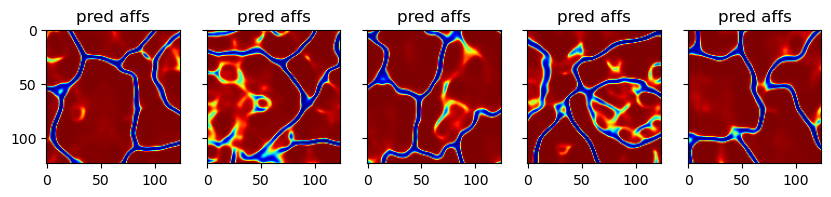

Training iteration 1599:  80%|███████▉  | 1600/2001 [05:47<01:26,  4.64it/s]INFO:gunpowder.nodes.generic_train:Train process: iteration=5601 loss=0.064231 time=0.016580


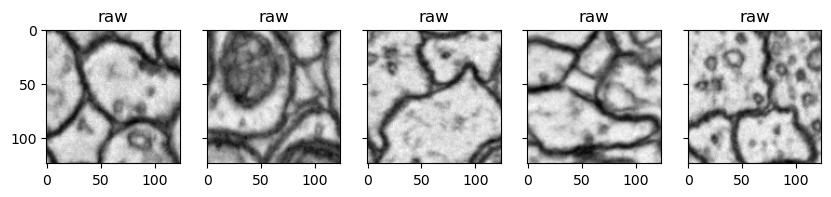

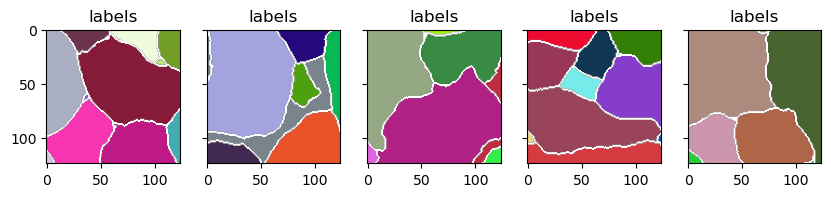

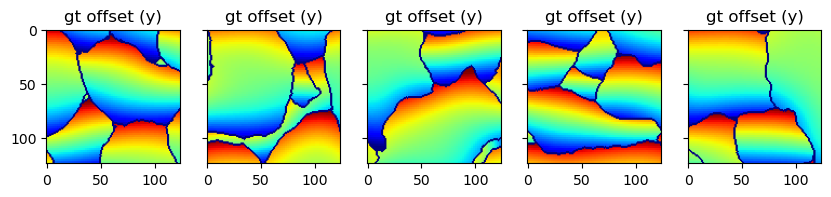

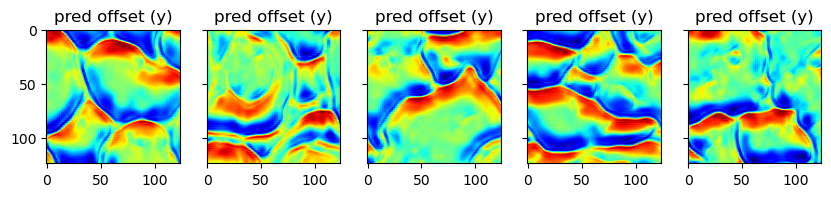

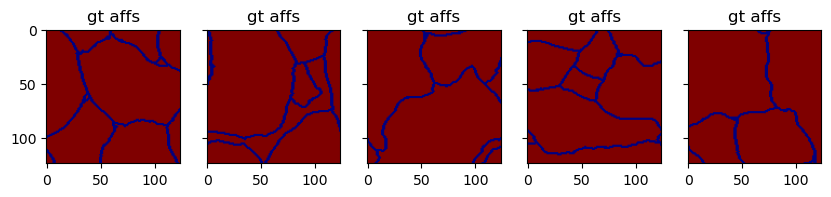

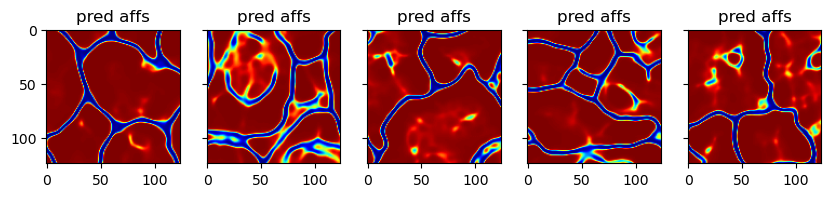

Training iteration 1799:  90%|████████▉ | 1800/2001 [06:29<00:38,  5.16it/s]INFO:gunpowder.nodes.generic_train:Train process: iteration=5801 loss=0.062032 time=0.015110


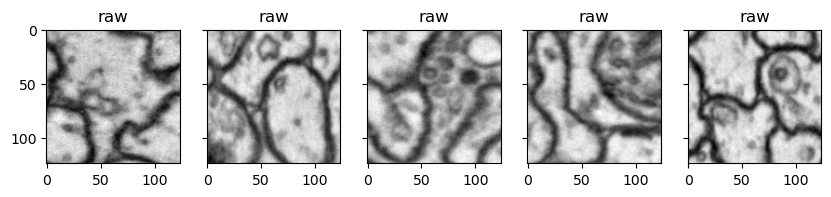

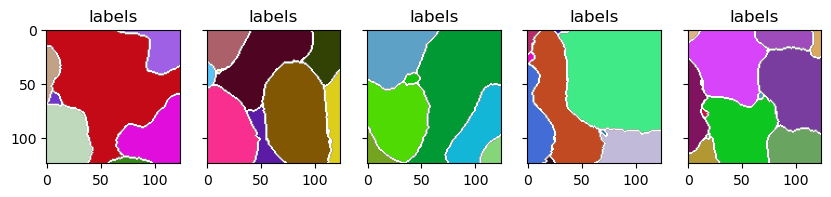

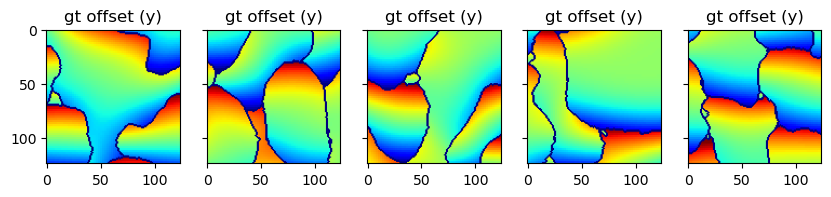

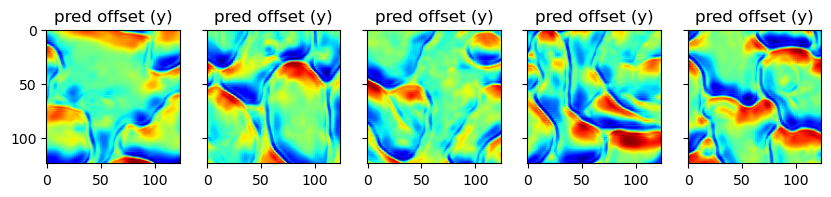

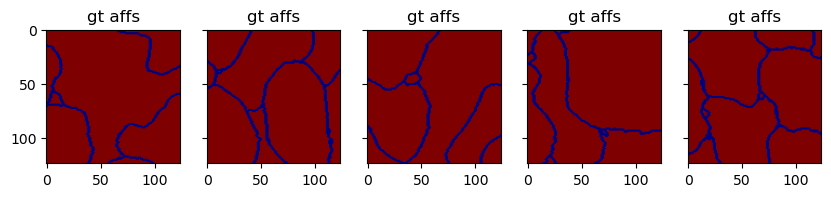

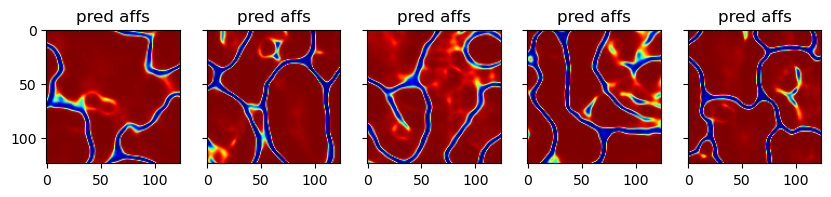

Training iteration 1998: 100%|█████████▉| 1999/2001 [07:11<00:00,  4.87it/s]INFO:gunpowder.torch.nodes.train:Creating checkpoint model_checkpoint_6000
INFO:gunpowder.nodes.generic_train:Train process: iteration=6000 loss=0.064303 time=0.118575
Training iteration 1999: 100%|█████████▉| 2000/2001 [07:12<00:00,  5.09it/s]INFO:gunpowder.nodes.generic_train:Train process: iteration=6001 loss=0.053725 time=0.015807


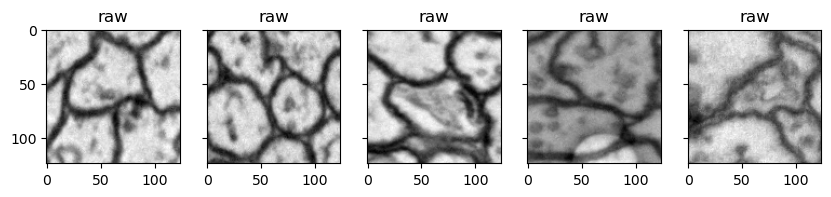

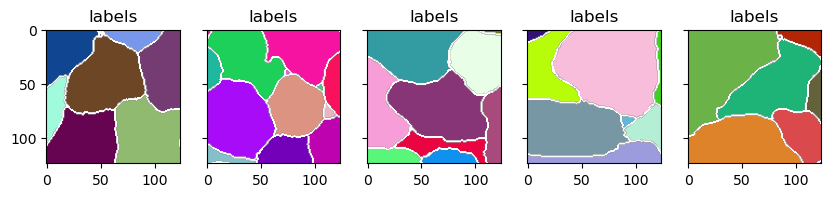

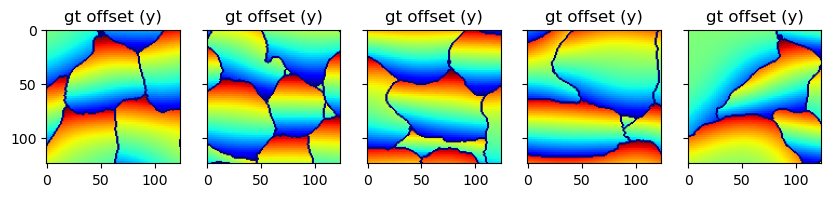

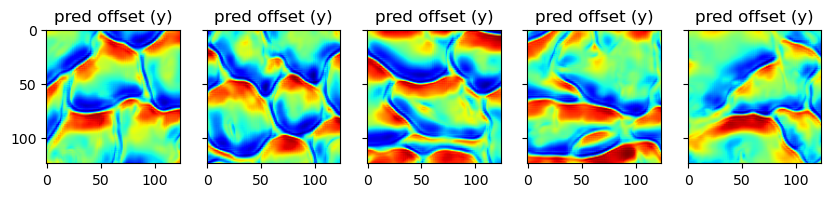

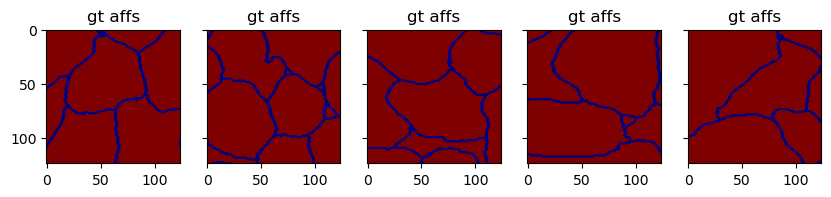

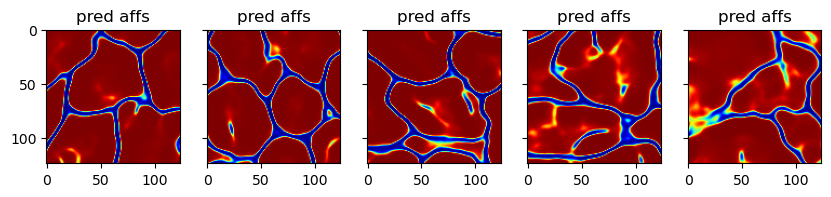

Training iteration 2000: 100%|██████████| 2001/2001 [07:15<00:00,  4.60it/s]INFO:gunpowder.producer_pool:terminating workers...
INFO:gunpowder.producer_pool:joining workers...
INFO:gunpowder.producer_pool:done



In [11]:
# lets just view the mean offset y channels
# train for ~1k iterations, view every 100th batch
# show the prediction as well as the ground truth

lsd_channels = {'offset (y)': 0}
aff_channels = {'affs': 0}

train(
    iterations=2001,
    show_every=200,
    show_pred=True,
    lsd_channels=lsd_channels,
    aff_channels=aff_channels)

*  Just a general idea of how to use gunpowder - the networks in the paper are all in 3d and should be trained on sufficient hardware

*  Results will probably vary since these are 2d slices of 3d data - sometimes more information is required in the z-dimension to inform predictions (especially for neuron segmentation). Feel free to try training for longer.

*  see how to run inference in **inference.ipynb**